In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from src.model import Generator, MappingNetwork, StyleEncoder

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F

import pandas as pd
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
color2idx = {
    'ash_brown': 3,
    'black': 1,
    'natural_brown': 5,
    'ombre': 0,
    'pink_brown': 4,
    'reddish_brown': 2,
    'yellowish_brown': 6
}

color2idx = {
    'ash brown': 3,
    'black': 1,
    'natural brown': 5,
    'Ombre': 0,
    'pink-brown': 4,
    'reddish brown': 2,
    'yellowish brown': 6
}

color2idx = {
    'blond': 0,
    'black': 1,
    'brown': 2
}

idx2color = dict(zip(color2idx.values(), color2idx.keys()))

In [4]:
# pth_path = 'checkpoints/100000_nets_ema.ckpt'
# num_domains = 7
pth_path = './expr_3domains/nets_ema.ckpt'
num_domains = 3
pth = torch.load(pth_path, map_location='cpu')
generator = Generator(w_hpf=0)
mapping_network = MappingNetwork(num_domains=num_domains)
style_encoder = StyleEncoder(num_domains=num_domains)

generator.load_state_dict(pth['generator'])
mapping_network.load_state_dict(pth['mapping_network'])
style_encoder.load_state_dict(pth['style_encoder'])

for model in  [generator, mapping_network, style_encoder]:
    model = model.eval()
    for p in model.parameters():
        p.requires_grad = False


transform = T.Compose([
        T.Resize([256, 256]),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
])
inv_transform = T.Compose([
    T.Lambda(lambda x: x * 0.5 + 0.5),
    T.ToPILImage()
])

df = pd.read_pickle('df_final.pkl')
root = 'partition1/images'
files = os.listdir(root)

paths = [os.path.join('/home/jupyter/mnt/datasets/k_hairstyle_full', root, file) for file in files]
df = df[df.path.isin(paths)]

# annot = pd.read_pickle('annotation.pkl')
# root = 'partition1/images'
# files = os.listdir(root)

# paths = [os.path.join(root, file) for file in files]
# annot = annot[annot.path.isin(paths)]
# annot = annot[annot.color.isin(list(color2idx.keys()))]
annot = df.copy()
annot.path = annot.path.apply(lambda x: '/'.join(x.split('/')[-3:]))

In [5]:
class HairDataset(Dataset):
    def __init__(self, annot, color2idx, transform=None):
        self.annot = annot
        self.color2idx = color2idx
        self.transform = transform
    
    def __len__(self):
        return len(self.annot)
    
    def __getitem__(self, idx):
        row = self.annot.iloc[idx]
        path = row.path
        color = row.color
        label = self.color2idx[color]
        image = Image.open(path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
batch_size = 4
dataset = HairDataset(annot, color2idx, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

1 black


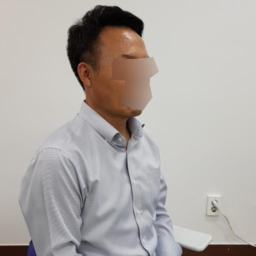

In [7]:
idx = np.random.randint(len(dataset))
image, label = dataset[idx]
print(label, idx2color[label])
inv_transform(image)

In [8]:
images, labels = next(iter(loader))

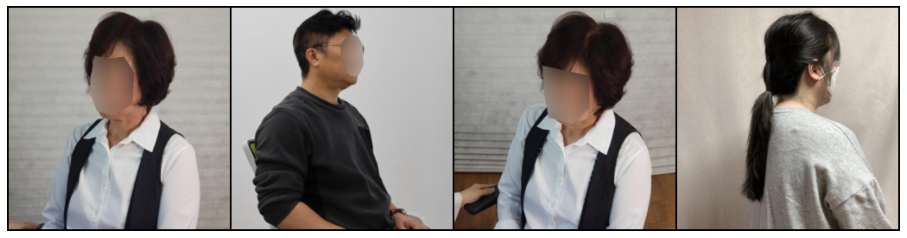

In [9]:
plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(images, batch_size, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [10]:
real_images, real_labels = next(iter(loader))

perm = torch.randperm(images.size(0))

ref_images = real_images.clone()[perm]
ref_labels = real_labels.clone()[perm]

ref_styles = style_encoder(ref_images, ref_labels)

fake_images = generator(real_images, ref_styles)

real_styles = style_encoder(real_images, real_labels)
recon_images = generator(fake_images, real_styles)



all_images = torch.cat((real_images, ref_images, fake_images, recon_images), dim=0)

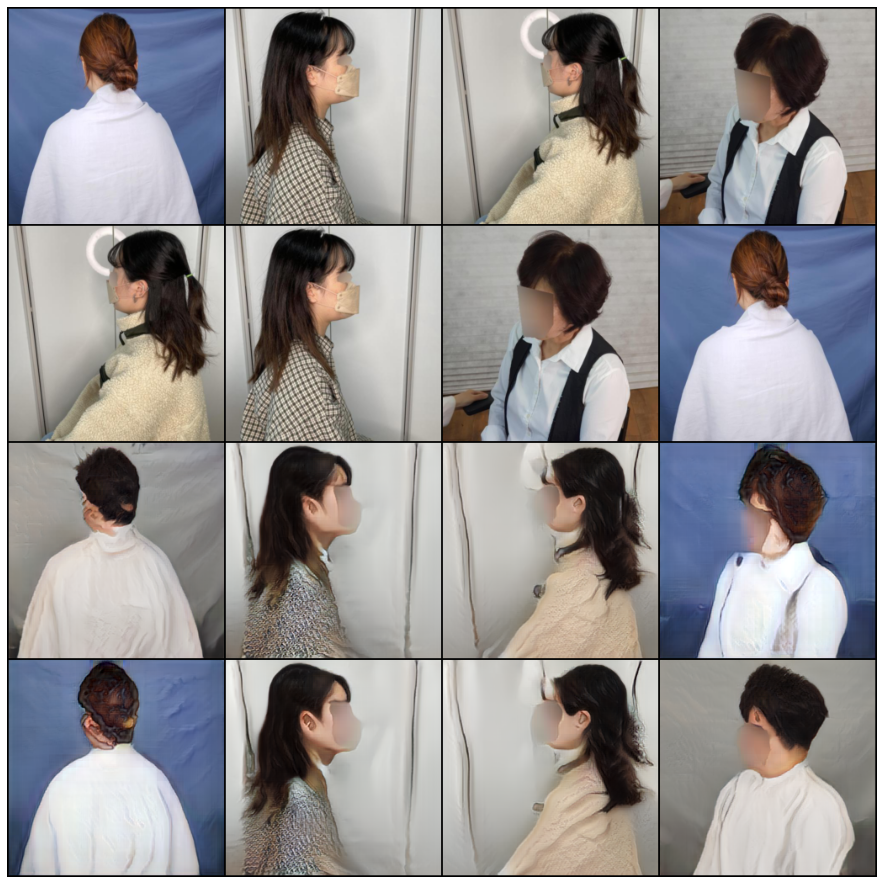

In [11]:
plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, batch_size, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [12]:
real_images, real_labels = next(iter(loader))

perm = torch.randperm(images.size(0))

# ref_images = images.clone()[perm]
latent_labels = real_labels.clone()[perm]
latent = torch.randn(real_images.size(0), 16)
fake_styles = mapping_network(latent, latent_labels)
# ref_styles = style_encoder(ref_images, ref_labels)


# fake_images = generator(real_images, ref_styles)
fake_images = generator(real_images, fake_styles)

# real_styles = style_encoder(real_images, real_labels)
real_styles = mapping_network(latent, real_labels)
recon_images = generator(fake_images, real_styles)



all_images = torch.cat((real_images, fake_images, recon_images), dim=0)

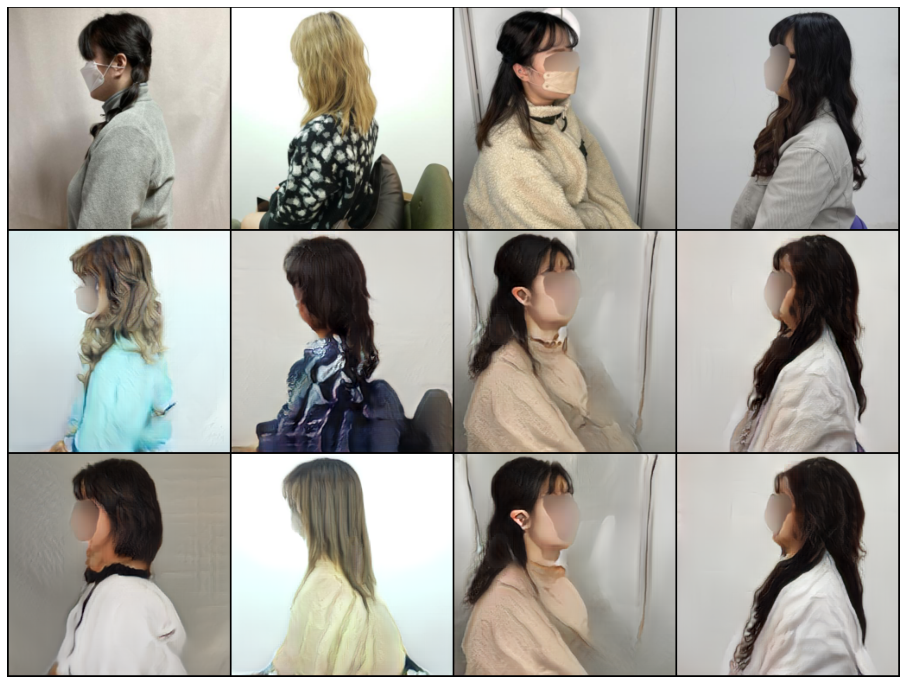

In [13]:
plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, batch_size, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [41]:
# blond -> black
# blond -> brown
# black -> blond
# black -> brown
# brown -> blond
# brown -> black

def get_real_images(dataset):
    taken = set()
    need_list = ['blond', 'blond', 'black', 'black', 'brown', 'brown']
    images, labels = [], []
    color = 'kek'
    idx = None
    for need_color in need_list:
        while color != need_color or idx in taken:
            idx = np.random.randint(len(dataset))
            image, label = dataset[idx]
            color = idx2color[label]
        images.append(image)
        labels.append(label)
        taken.add(idx)
    images = torch.stack(images)
    labels = torch.LongTensor(labels)
    return images, labels


def get_ref_images(dataset):
    taken = set()
    need_list = ['black', 'brown', 'blond', 'brown', 'blond', 'black']
    images, labels = [], []
    color = 'kek'
    idx = None
    for need_color in need_list:
        while color != need_color or idx in taken:
            idx = np.random.randint(len(dataset))
            image, label = dataset[idx]
            color = idx2color[label]
        images.append(image)
        labels.append(label)
        taken.add(idx)
    images = torch.stack(images)
    labels = torch.LongTensor(labels)
    return images, labels

In [42]:
real_images, real_labels = get_real_images(dataset)
ref_images, ref_labels = get_ref_images(dataset)

all_images = torch.cat([real_images, ref_images], dim=0)

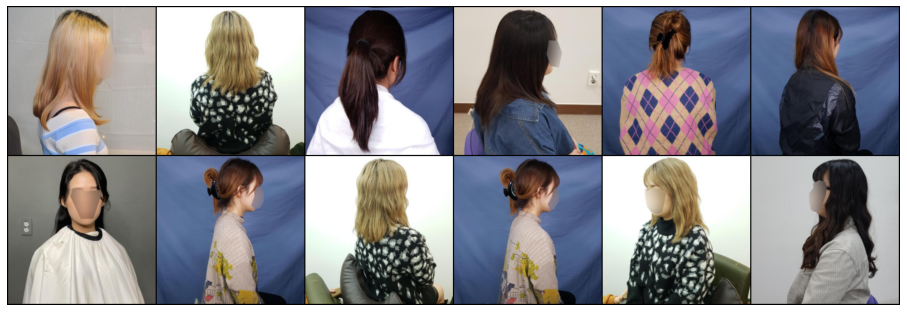

In [43]:
plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, 6, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

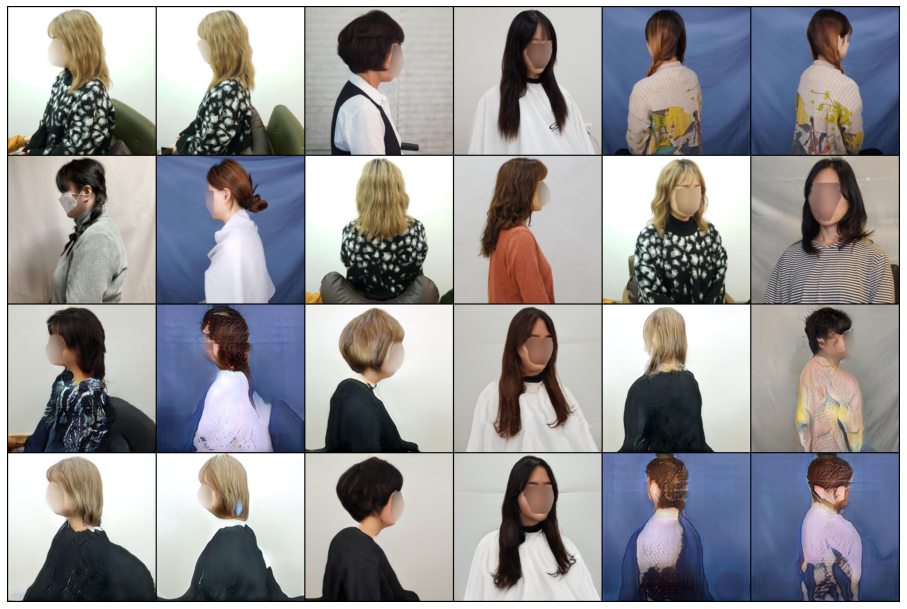

In [44]:
real_images, real_labels = get_real_images(dataset)
ref_images, ref_labels = get_ref_images(dataset)

ref_styles = style_encoder(ref_images, ref_labels)

fake_images = generator(real_images, ref_styles)

real_styles = style_encoder(real_images, real_labels)
recon_images = generator(fake_images, real_styles)



all_images = torch.cat((real_images, ref_images, fake_images, recon_images), dim=0)

plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, 6, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

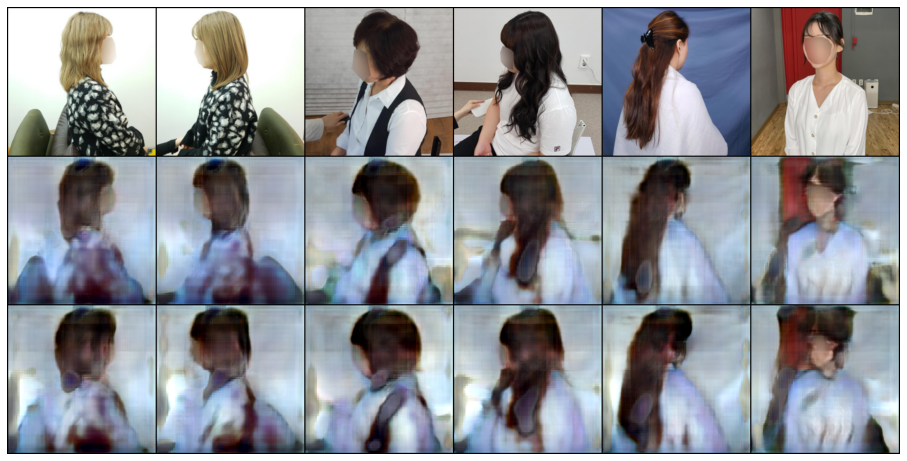

In [48]:
real_images, real_labels = get_real_images(dataset)
ref_images, ref_labels = get_ref_images(dataset)

latent_labels = ref_labels.clone()
latent = torch.randn(10_000, real_images.size(0), 16)
latent = torch.mean(latent, dim=0)
fake_styles = mapping_network(latent, latent_labels)
# ref_styles = style_encoder(ref_images, ref_labels)


# fake_images = generator(real_images, ref_styles)
fake_images = generator(real_images, fake_styles)

# real_styles = style_encoder(real_images, real_labels)
real_styles = mapping_network(latent, real_labels)
recon_images = generator(fake_images, real_styles)



all_images = torch.cat((real_images, fake_images, recon_images), dim=0)

plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, 6, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [50]:
image = Image.open('me/me.jpg')
image = transform(image)

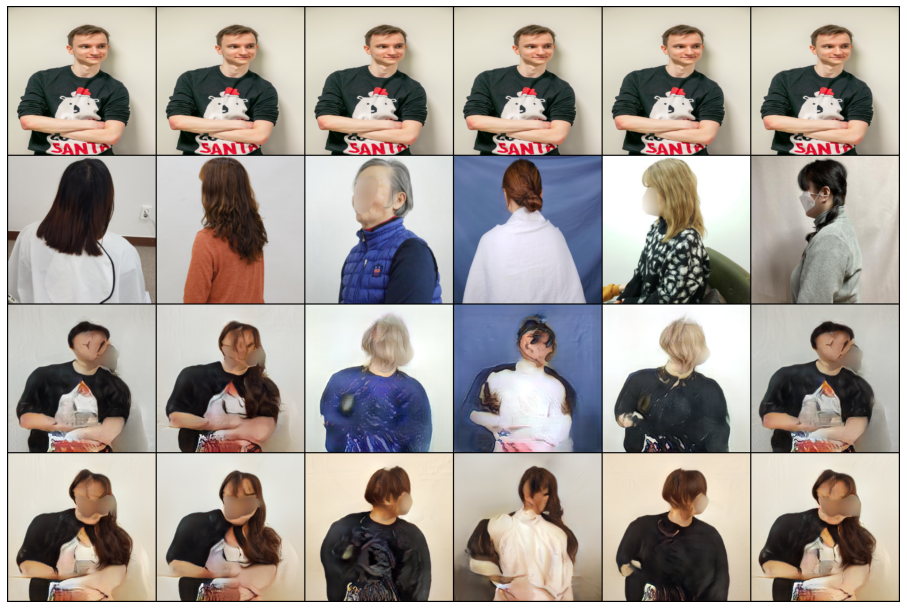

In [52]:
# real_images, real_labels = get_real_images(dataset)
real_images = torch.stack([image for _ in range(6)])
real_labels = torch.LongTensor([2] * 6)
ref_images, ref_labels = get_ref_images(dataset)

ref_styles = style_encoder(ref_images, ref_labels)

fake_images = generator(real_images, ref_styles)

real_styles = style_encoder(real_images, real_labels)
recon_images = generator(fake_images, real_styles)



all_images = torch.cat((real_images, ref_images, fake_images, recon_images), dim=0)

plt.figure(figsize=(16, 16))
plt.imshow(torchvision.utils.make_grid(all_images, 6, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [61]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [54]:
def to_int(x):
    return ((x * 0.5 + 0.5) * 255.).byte()

In [58]:
from tqdm.auto import tqdm

In [59]:
fid = FrechetInceptionDistance(feature=64)

for _ in tqdm(range(10)):
    real_images, real_labels = get_real_images(dataset)
    ref_images, ref_labels = get_ref_images(dataset)

    ref_styles = style_encoder(ref_images, ref_labels)

    fake_images = generator(real_images, ref_styles)

    real_styles = style_encoder(real_images, real_labels)
    recon_images = generator(fake_images, real_styles)


    fid.update(to_int(real_images), real=True)
    fid.update(to_int(ref_images), real=True)

    fid.update(to_int(fake_images), real=False)
    fid.update(to_int(recon_images), real=False)

fid.compute()

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.9991)

In [60]:
fid = FrechetInceptionDistance(feature=64)

real_images, real_labels = get_real_images(dataset)
ref_images, ref_labels = get_ref_images(dataset)

ref_styles = style_encoder(ref_images, ref_labels)

fake_images = generator(real_images, ref_styles)

real_styles = style_encoder(real_images, real_labels)
recon_images = generator(fake_images, real_styles)


# fid.update(to_int(real_images), real=True)
# fid.update(to_int(ref_images), real=True)

fid.update(to_int(fake_images), real=False)
fid.update(to_int(recon_images), real=False)

fid.compute()

ValueError: No samples to concatenate

In [67]:
scores = []
lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')

n_iter = 10
for _ in tqdm(range(n_iter)):
    real_images, real_labels = get_real_images(dataset)
    ref_images, ref_labels = get_ref_images(dataset)

    ref_styles = style_encoder(ref_images, ref_labels)

    fake_images = generator(real_images, ref_styles)

    real_styles = style_encoder(real_images, real_labels)
    recon_images = generator(fake_images, real_styles)


# fid.update(to_int(real_images), real=True)
# fid.update(to_int(ref_images), real=True)
    with torch.no_grad():
        score = lpips(real_images * 0.5 + 0.5, recon_images.clip(-1, 1) * 0.5 + 0.5)
        score = score.item()
    scores.append(score)

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
np.mean(scores)

0.37134904861450196